## Target- urgent withdrawn by nurse(within 24hr)
* shift_applications status == 'cancelled' + shift_application prevStatus == 'confirmed'


### IDs -> only look at shifts application, leave each shifts after
* shift_applications id
* shift_applications user_id
* shift_applications shift_id


### Numeric Field
* shifts rate
* shifts net_pay: rate - nursedash profit
* shift_applications distance
* shift break time
* user withdrawn times: 
    Problem: 
        1. We don't know in reality that you will withdraw your previous one.
        2. cannot be used to predict new user
* user applied times:
* <b>prev SA/CW rate<b/>


## Time
### shift, shift app time
* S_Create (shift created) => SA_Create (application created) => CWTime (comfim withdrawn) => Start_Time (shift start)
* S_Create: shift create time
* SA_Create: shift application create time
* CWTime: shift withdrawn time, whole confirmed withdrawn population (include within 24hr and > 24hr)
* Start_Time: shift start time
##### calculated field, graph in hours
* <b>S_Create2SA_Create<b/>: shift application create time - shift create time
* <b>S_Create2Start_Time<b/>: shift start time - shift create time
        1. has negative values. delete maybe?
* <b>SA_Create2Start_Time<b/>: shift start time - shift application create time
        1. has negative values. delete maybe?

### User
* user approvedAt:
* user createdAt:
#### Calculated field
* U_Create2U_approved: User approve time - User create time
* <b>U_Create2now<b/>: now - User create time, in months(seconds/2629746)
* <b>U_Approve2now<b/>: now - User approve time


### Categorical
* shifts role: position name + type
* facilities name = facilities short_name
* facilities areaId = facilities areaName
* withdrawnInfo_key, withdrawnInfo_value
* facilities segmentName: Senior Living = 1, Healthcare = 0
* Users enableNotifications:
* Users emailNotifications:
* Users appNotifications:
* Users allowedNotifications:


### ?
* facilities allowedQualification
* facilities createdAt
* facilities rates
* nurse shift withdrawn by admin, when policy start, how many withdrawn by admin
* shifts = unit
* role
* users updateAt ?
* users relationToFacility

# Data Cleaning

In [160]:
import pandas as pd

In [161]:
df = pd.read_csv('main.csv')

In [162]:
df.columns

Index(['Unnamed: 0', 'id', 'user_id', 'shift_id', 'status', 'createdAt',
       'hasNurseCheckEvent', 'hasBreakTime', 'prevStatus', 'distance', 'id.1',
       'facility_id', 'description', 'start_time', 'assigned_nurse_id', 'rate',
       'net_pay', 'unit', 'type', 'createdAt.1', 'qualifications', 'breakTime',
       'prevStatus.1', 'id.2', 'name', 'short_name', 'createdAt.2', 'rates',
       'S_Create', 'SA_Create', 'S_create2SA_Create', 'Start_Time',
       'SA_Create2Start_Time', 'S_Create2Start_Time', 'CW_Time',
       'CW_Time2Start_Time', 'SA_Create2CW_Time', 'S_Create2CW_Time',
       'allowedQualifications', 'areaId', 'areaName', 'segmentName',
       'U_create2now', 'U_approve2now', 'U_create2U_approve',
       'withdrawnInfo_key', 'withdrawnInfo_value', 'tar'],
      dtype='object')

In [163]:
df.shape

(169654, 48)

In [164]:
#df['tar'] = df.apply(lambda x: 1 if x['status'] == 'withdrawn' and x['prevStatus'] == 'confirmed' and x['withdrawnInfo_value'] == 'nurse' and df['CW_Time2Start_Time'] > -24 else 0, axis =1)

In [165]:
def CW_by_nurse(row):
    if row['status']=='withdrawn' and row['prevStatus'] == 'confirmed':
        if row['withdrawnInfo_value'] == 'nurse':
            if row['CW_Time2Start_Time'] < 0 and row['CW_Time2Start_Time'] >= -24:
                return 1
            else:
                return 0
        else:
            return 0
    else:
        return 0
    
df['target'] = df.apply (lambda row: CW_by_nurse(row), axis=1)

In [166]:
df['target'].value_counts()

0    165284
1      4370
Name: target, dtype: int64

#### Calculated field
* U_Create2U_approve: User approve time - User create time
* U_Create2now: now - User create time, in months(seconds/2629746)
* U_Approve2now: now - User approve time

In [167]:
import seaborn as sns
from matplotlib import pyplot

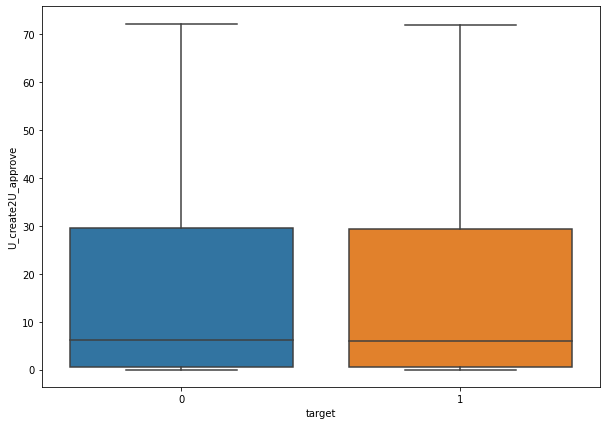

In [168]:
# U_create to U_approve (by hours)
size = (10, 7)
fig, ax = pyplot.subplots(figsize=size)
sns.boxplot(data = df,x = "target", y = "U_create2U_approve",showfliers=False)

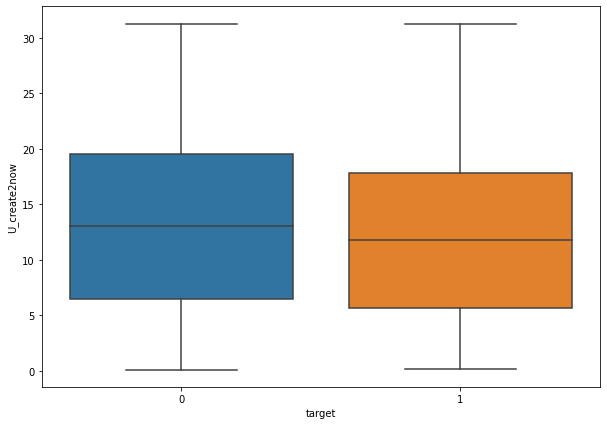

In [169]:
# U_create to now (by month)
size = (10, 7)
fig, ax = pyplot.subplots(figsize=size)
sns.boxplot(data = df,x = "target", y = "U_create2now",showfliers=False)

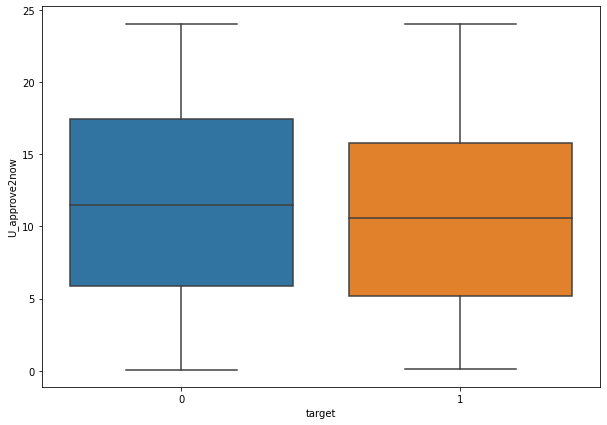

In [170]:
# U_approve to now (by month)
size = (10, 7)
fig, ax = pyplot.subplots(figsize=size)
sns.boxplot(data = df,x = "target", y = "U_approve2now",showfliers=False)

##### calculated field, graph in hours
* S_Create2SA_Create: shift application create time - shift create time
* S_Create2Start_Time: shift start time - shift create time
* SA_Create2Start_Time: shift start time - shift application create time

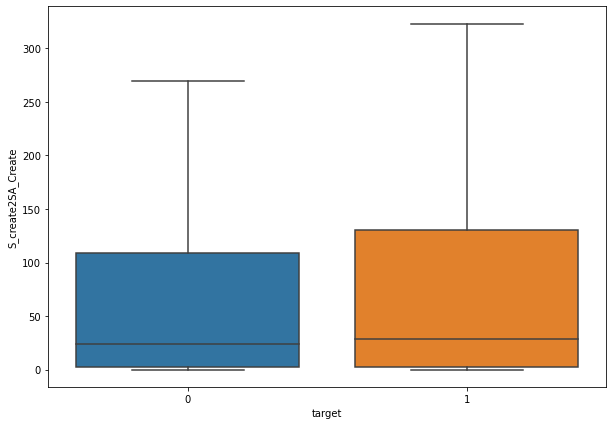

In [171]:
# S_Create to SA_Create (by hour)
size = (10, 7)
fig, ax = pyplot.subplots(figsize=size)
sns.boxplot(data = df,x = "target", y = "S_create2SA_Create",showfliers=False)

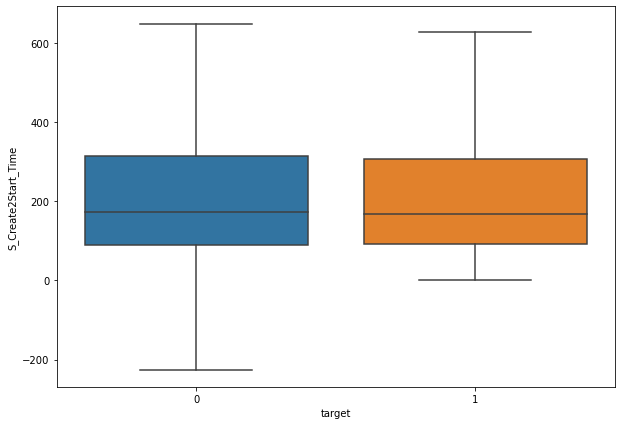

In [172]:
# S_Create to Start_Time (by hour)
size = (10, 7)
fig, ax = pyplot.subplots(figsize=size)
sns.boxplot(data = df,x = "target", y = "S_Create2Start_Time",showfliers=False)

In [173]:
# There are some negative numbers in this column. Not very much. 
# I think we need to delete these data entries since it make it impossible to nurse to apply on time.
df[df["S_Create2Start_Time"]<0].shape[0]

388

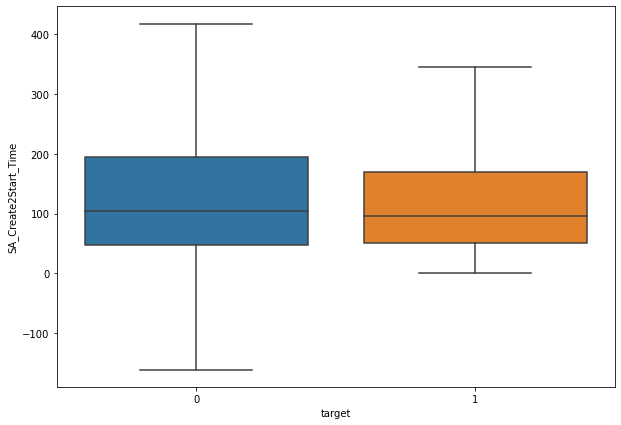

In [174]:
# SA_Create to Start_Time (by hour)
size = (10, 7)
fig, ax = pyplot.subplots(figsize=size)
sns.boxplot(data = df,x = "target", y = "SA_Create2Start_Time",showfliers=False)

In [175]:
# There are some negative numbers in this column. Not very much. 
# I think we need to delete these data entries since it make it impossible to nurse to apply on time.
df[df["SA_Create2Start_Time"]<0].shape[0]

1931

In [176]:
import numpy as np

In [177]:
# df2 is a sorted version of df1, data is exactly the same
df1 = df.set_index(['user_id','id'])
df2 = df1.sort_index()
df2 = df2.reset_index()

In [178]:
# df2.head(50)

In [179]:
def count_prev_SA(df):
    count_prev_SA = []
    id_number = 0
    count = 0
    user_id = list(df2['user_id'])
    for i in user_id:
        if id_number == i:
            count += 1
            count_prev_SA.append(count)
            id_number = i
        else:
            count = 0
            count_prev_SA.append(count)
            id_number = i
    return count_prev_SA

        
df2['count_prev_SA'] = count_prev_SA(df2)

In [180]:
def count_prev_CW(df):
    count_prev_CW = []
    id_number = 0
    count = 0
    user_id = list(df2['user_id'])
    urgent_CW = list(df2['target'])
    for i,v in enumerate(user_id):
        if id_number == v:
            count_prev_CW.append(count)
            if urgent_CW[i] == 1:
                count += 1
            id_number = v
        else:
            count = 0
            count_prev_CW.append(count)
            if urgent_CW[i] == 1:
                count += 1
            id_number = v
    return count_prev_CW

        
df2['count_prev_CW'] = count_prev_CW(df2)

In [181]:
df2['prev_CW/SA_rate'] = df2['count_prev_CW']/df2['count_prev_SA']
df2['prev_CW/SA_rate'].fillna(0,inplace=True)

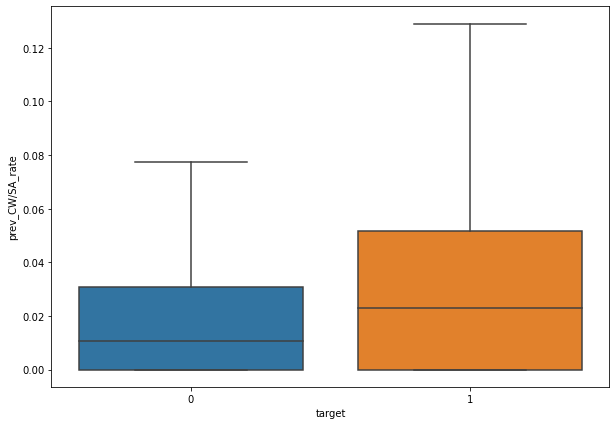

In [182]:
# prev_CW/SA_rate
size = (10, 7)
fig, ax = pyplot.subplots(figsize=size)
sns.boxplot(data = df2,x = "target", y = "prev_CW/SA_rate",showfliers=False)

### Additional User Analysis for potential user analysis

In [183]:
user_info = pd.DataFrame(df1.groupby('user_id')['target'].sum()).drop(['target'], axis=1)
count_CW = list(df1.groupby('user_id')['target'].sum())
count_SA = list(df1.groupby('user_id')['target'].count())
user_info['count_CW'] = count_CW
user_info['count_SA'] = count_SA
user_info['CW/SA_rate'] = user_info['count_CW']/user_info['count_SA']

In [184]:
user_info

,count_CW,count_SA,CW/SA_rate
user_id,,,
18,0,63,0.000000
31,2,145,0.013793
32,0,4,0.000000
38,0,7,0.000000
39,0,8,0.000000
...,...,...,...
16986,0,2,0.000000
17002,0,4,0.000000
17027,0,1,0.000000


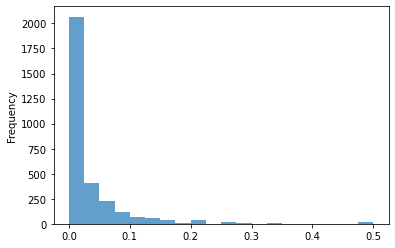

In [185]:
# User CW/SA_rate distribution
user_info['CW/SA_rate'].plot.hist(bins=20, alpha=0.7)

# Numeric Field
### shifts rate

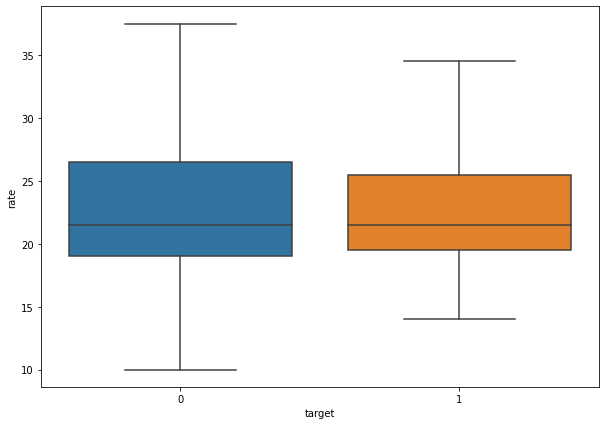

In [186]:
size = (10, 7)
fig, ax = pyplot.subplots(figsize=size)
sns.boxplot(data = df2,x = "target", y = "rate",showfliers=False)

### <font color = red> useless

### shifts net_pay: rate - nursedash profit

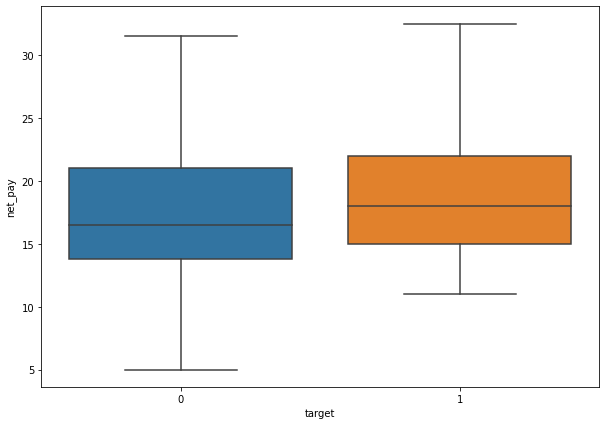

In [187]:
size = (10, 7)
fig, ax = pyplot.subplots(figsize=size)
sns.boxplot(data = df,x = "target", y = "net_pay",showfliers=False)

### <font color = red> useless

### shift_applications distance, box plot bad

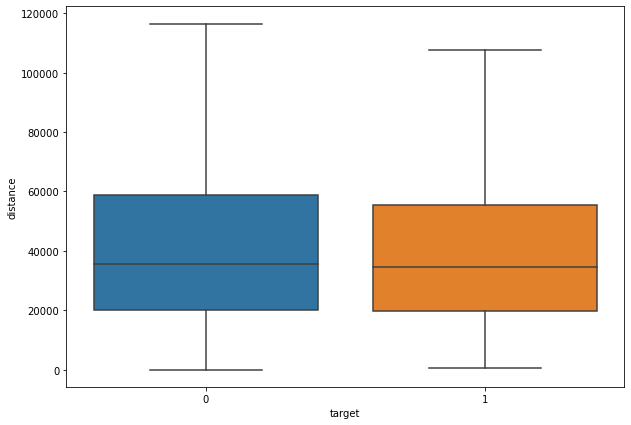

In [188]:
size = (10, 7)
fig, ax = pyplot.subplots(figsize=size)
sns.boxplot(data = df,x = "target", y = "distance",showfliers=False)

### <font color = red> useless

# Categorical
### shifts role: position name + type, only type


In [189]:
test1 = pd.DataFrame(df2.groupby('type')['target'].count().reset_index(name = 'total count'))

In [190]:
test1 = pd.DataFrame(df2.groupby('type')['target'].count().reset_index(name = 'total count'))

shiftrole_cw = df2[df['target'].apply(lambda x: x == 1)]
test2 = pd.DataFrame(shiftrole_cw.groupby('type')['target'].count().reset_index(name = 'cw count'))

g1 = test1.merge(test2, on = 'type', how = 'left')

g1['rf'] = g1.apply(lambda x: x['cw count']/x['total count'], axis = 1)

g1.sort_values(by = 'rf', ascending = False)

,type,total count,cw count,rf
6,Tech,1070,34,0.031776
0,CMA/Med-Tech,6345,172,0.027108
5,STNA,40486,1058,0.026132
1,CNA,86989,2256,0.025934
3,LVN,16449,420,0.025533
4,RN,11755,279,0.023735
2,LPN,6560,151,0.023018


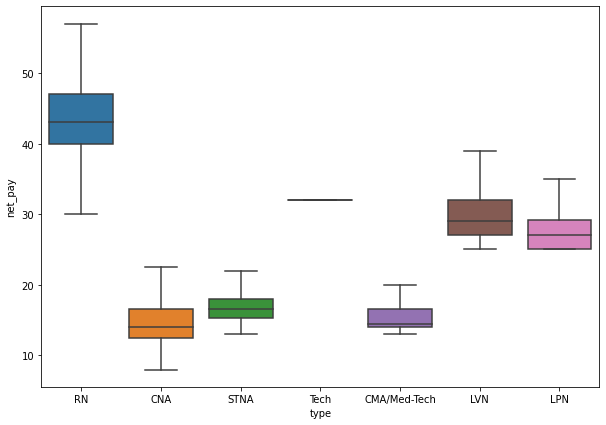

In [191]:
# prev_CW/SA_rate
size = (10, 7)
fig, ax = pyplot.subplots(figsize=size)
sns.boxplot(data = df2,x = 'type', y = 'net_pay',showfliers=False)

In [192]:
# create type dummy: RN = 1, LVN + LPN = 2, rest = 0
def create_type_dummy(row):
    if row['type']=='RN':
        return 1
    elif row['type'] == 'LVN' or row['type'] == 'LPN':
        return 2
    else:
        return 0
    
df2['type_d'] = df2.apply(lambda row: create_type_dummy(row), axis=1)

In [193]:
df2['type_d']

0         1
1         1
2         1
3         1
4         1
         ..
169649    2
169650    2
169651    2
169652    2
169653    2
Name: type_d, Length: 169654, dtype: int64

### <font color = red> three dummmy, RN, LVN + LPN, rest

### facilities name = facilities short_name

In [194]:
df2['short_name'].value_counts().reset_index(name = 'count').head(20)

,index,count
0,MTF-SNF,9795
1,MCG,7619
2,SCV,4880
3,ADH-Heights,4620
4,BRE,4063
5,ABP,3927
6,NXCH,3573
7,VOH,3473
8,WEI,3444
9,PMSB,3108


### <font color = red> later with areaID

### facilities areaId = facilities areaName

In [195]:
df2['areaName'].value_counts()

Houston           85321
Northeast Ohio    47353
DFW               27350
Austin             6120
San Antonio        3451
Cincinnati           59
Name: areaName, dtype: int64

/Users/fufufu/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


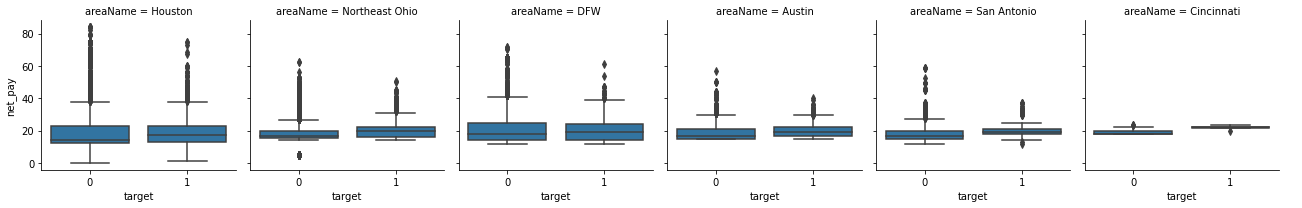

In [196]:
import matplotlib.pyplot as plt
g = sns.FacetGrid(df2, col = 'areaName')
# Notice hwo the arguments come after plt.scatter call
g = g.map(sns.boxplot, 'target', 'net_pay').add_legend()

### <font color = red> later with areaID

### withdrawnInfo_value need to trace forward

In [197]:
df2['withdrawnInfo_value'].value_counts()[:10]

nurse                                  27767
admin                                   6492
Set "do not return" to the facility     1350
Set nurse status to on hold             1099
Family emergency                         342
Wrong shift                              332
Wrong shift                              260
Not available                            259
Wrong date                               229
Unavailable                              213
Name: withdrawnInfo_value, dtype: int64

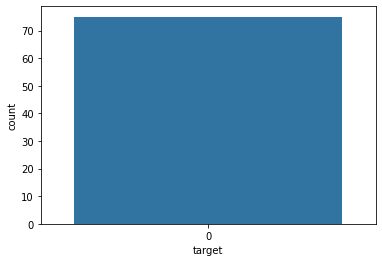

In [198]:
w_familyemergency = df2[df2['withdrawnInfo_value'].apply(lambda x: x == 'Family emergency')]
sns.countplot(x = 'target', data = w_familyemergency)

In [199]:
userindex = list(df2[df2['withdrawnInfo_value'].apply(lambda x: x == 'Family emergency')]['user_id'])
userindex[:3]

[230, 568, 664]

In [200]:
# list(df2[df2['user_id'].apply(lambda x: x == 568)]['withdrawnInfo_value'])
# 'Confirmed to work elsewhere ',
# 'Confirmed for shift elsewhere; applied to this shift several days ago without a response',

In [201]:
# list(df2[df2['user_id'].apply(lambda x: x == 664)]['withdrawnInfo_value'])
# 'Got another shift on nursedash',
# 'The time is past and my application was not approved',

#### 'Set nurse status to on hold'

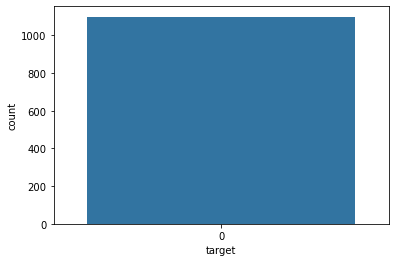

In [202]:
w_familyemergency = df2[df2['withdrawnInfo_value'].apply(lambda x: x == 'Set nurse status to on hold')]
sns.countplot(x = 'target', data = w_familyemergency)

In [203]:
userindex = list(df2[df2['withdrawnInfo_value'].apply(lambda x: x == 'Set nurse status to on hold')]['user_id'])
userindex[:3]

[194, 405, 555]

In [204]:
list(df2[df2['user_id'].apply(lambda x: x == 405)]['withdrawnInfo_value'])

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'admin',
 nan,
 'admin',
 nan,
 'nurse',
 'Working a different location ',
 'admin',
 nan,
 'nurse',
 'Another location',
 nan,
 nan,
 nan,
 'nurse',
 'Not feeling well running a temp',
 'nurse',
 'Picked up another shift',
 nan,
 nan,
 nan,
 'nurse',
 'Corfirmed for another shift',
 'admin',
 'Set nurse status to on hold',
 nan]

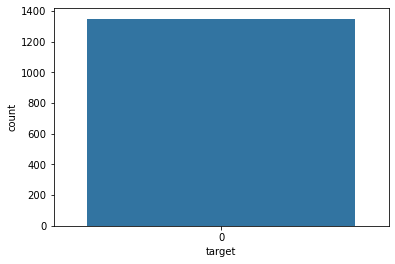

In [205]:
w_familyemergency = df2[df2['withdrawnInfo_value'].apply(lambda x: x == 'Set "do not return" to the facility')]
sns.countplot(x = 'target', data = w_familyemergency)

### <font color = red> can they still apply after with these 3 withdrawn info, what are the cw rate

### facilities segmentName: Senior Living = 1, Healthcare = 0


In [206]:
Senior_Living = df2[df2.apply(lambda x: x['segmentName'] == 'Senior Living', axis = 1)]
Healthcare = df2[df2.apply(lambda x: x['segmentName'] == 'Healthcare', axis = 1)]
Senior_Living['target'].value_counts()

0    144526
1      4110
Name: target, dtype: int64

In [207]:
4110/(144526+4110)

0.02765144379558115

In [208]:
Healthcare['target'].value_counts()

0    20758
1      260
Name: target, dtype: int64

In [209]:
260/(20758+260)

0.01237034922447426

/Users/fufufu/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


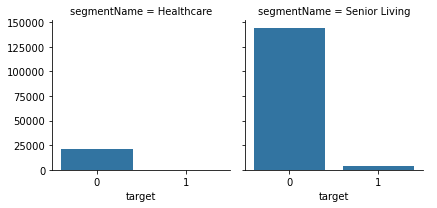

In [210]:
import matplotlib.pyplot as plt
g = sns.FacetGrid(df, col = 'segmentName')
# Notice hwo the arguments come after plt.scatter call
g = g.map(sns.countplot, 'target').add_legend()

In [211]:
# create type dummy: Senior Living, Healthcare
def create_segmentName_dummy(row):
    if row['segmentName']=='Senior Living':
        return 1
    else:
        return 0
    
df2['segmentName_d'] = df2.apply(lambda row: create_segmentName_dummy(row), axis=1)

### <font color = red> dummy

* Users enableNotifications:
* Users emailNotifications:
* Users appNotifications:
* Users allowedNotifications:

### <font color = red> didnt download

In [212]:
# df2['type_d']
# RN = 1, LVN + LPN = 2, rest = 0
# Senior Living = 1, Healthcare = 0
# df2['segmentName_d'] 